<h1 style="text-align: center; font-size: 40px">Predicting Blood-Brain Barrier Permeability<br> from SMILES Using Machine Learning</h1>

<h2 style="text-align: center; font-size: 40px">Introduction</h2>

<style>
.centered-list { 
    text-align: center;
    list-style-position: inside; 
    padding: 0;
    margin: 0;
        } 
</style>

<p style="text-align:justify; font-size: 17px; text-indent: 10px">The blood-brain barrier (BBB) is a critical physiological structure that protects the central nervous system by regulating the passage of substances from the bloodstream into the brain. Due to its selective permeability, predicting whether a molecule can cross the BBB is a key step in the early stages of drug discovery, especially for compounds targeting neurological conditions (<a href="https://doi.org/10.1124/mi.3.2.90">W. M. Pardridge</a>).<p>
<p style="text-align:justify; font-size: 17px; text-indent: 10px">In this notebook, a binary classification model is developed to predict BBB permeability based on molecular representations in SMILES (Simplified Molecular Input Line Entry System) format. A chemical informatic tool, RDKit, is used to process molecular structures, and Mordred is employed to compute a wide range of molecular descriptors. These descriptors serve as input features for training a Random Forest classifier.<p>
<p style="text-align:justify; font-size: 17px; text-indent: 10px">The model is optimized using GridSearchCV. Evaluation is focused on maximizing the recall for non-permeable compounds, thereby reducing false positives — compounds incorrectly predicted as BBB-permeable — which is essential to prevent ineffective or unsafe molecules from advancing in the drug development pipeline.</p>
<center><img src="./Images/adfm202404234-fig-0001-m.jpg" alt="Brain Blood Barrier Scheme"></center>
<h3 style="text-align: center; font-size: 15px">Brain Blood Barrier Scheme (source: <a href="https://doi.org/10.1002/adfm.202404234")>Cai et al.</a>)</h3>
<br>
<br>
<h3 align="center">Workflow Overview</h3>
<div style="text-align: center; font-size: 16px">
    <ol style="display: inline-block; text-align: left">
        <li>Data Loading: Import SMILES strings and BBB permeability labels.</li>
        <li>Feature Extraction: Use RDKit and Mordred to compute molecular descriptors.</li>
        <li>Data Preprocessing: Clean and split the dataset into training and testing subsets.</li>
        <li>Model Building and Tuning: Construct a pipeline using a Random Forest classifier and apply GridSearchCV.</li>
        <li>Evaluation: Measure model performance with recall, confusion matrix, and other metrics.</li>
        <li>Conclusion: Analyze feature importance and assess model strengths and limitations.</li>
    </ol>
</div>


<h2 style="text-align: center; font-size: 40px">1. Data Loading</h2>


In [5]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install rdkit
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

#!pip install git+https://github.com/mordred-descriptor/mordred
from mordred import Calculator
from mordred.AtomCount import AtomCount
from mordred.HydrogenBond import HBondAcceptor, HBondDonor
from mordred.Polarizability import APol
from mordred.RingCount import RingCount
from mordred.RotatableBond import RotatableBondsRatio
from mordred.SLogP import SLogP
from mordred.TopologicalCharge import TopologicalCharge
from mordred.TopologicalIndex import Radius, TopologicalShapeIndex
from mordred.TopoPSA import TopoPSA
from mordred.Weight import Weight
from mordred.ZagrebIndex import ZagrebIndex

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

In [6]:
# Load Dataset
bbb_df = pd.read_csv('./DataSets/BBBP.csv')
bbb_df.drop('num', axis=1, inplace=True)
bbb_df.set_index('name', inplace=True)
bbb_df = bbb_df.sort_index()
bbb_df.rename(columns={'p_np':'BBB_permeable'},inplace=True)
bbb_df.head()

,BBB_permeable,smiles
name,,
"""1,1,1-Trifluro-2-chloroethane""",1,ClCC(F)(F)F
"""2,2-dimethylbutane""",1,CCC(C)(C)C
1-47,0,NCCc1cn2c(n1)cccc2
1-48,1,CCCN(CCC)CCc1ccc(c2c1CC(N2)=C)O
1-hydroxymidazolam,1,OCc1ncc2CN=C(c3ccccc3F)c4cc(Cl)ccc4n12


<Axes: xlabel='BBB_permeable', ylabel='Count'>

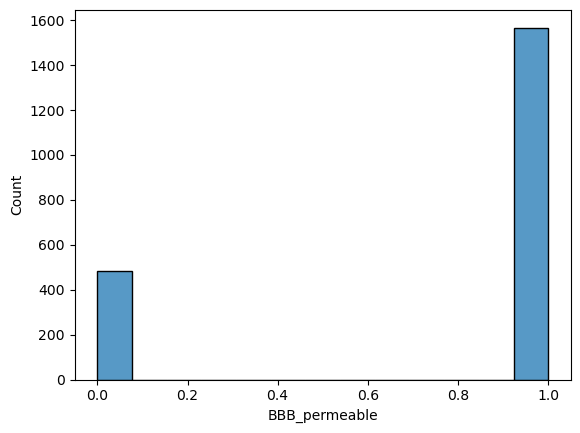

In [7]:
# Explore permeable/non-permeable proportion
sns.histplot(data=bbb_df['BBB_permeable'])

<p style="text-align:justify; font-size: 17px; text-indent: 10px">The target variable is imbalanced: approximately 75% of the samples belong to class 1
and 25% to class 0. Therefore, when splitting the data into training and test sets,
I will use the 'stratify' parameter to preserve the original class distribution in both subsets.</p>

<h2 style="text-align: center; font-size: 40px">2. Feature Extraction</h2>

<p style="text-align:justify; font-size: 17px; text-indent: 10px">In the following cell, I compute a variety of physicochemical and topological molecular descriptors for each compound based on their SMILES representation. These descriptors will be used for subsequent model training. Below is a brief description of each descriptor:

- **Molecular weight**: The total molecular weight of the compound.
- **Topological polar surface area (TPSA)**: Estimates the surface area occupied by polar atoms; correlated with drug absorption.
- **SLogP**: The predicted octanol/water partition coefficient (logP), representing lipophilicity.
- **H-bond acceptors**: Number of hydrogen bond acceptor atoms (typically N and O).
- **H-bond donors**: Number of hydrogen bond donor atoms (typically N-H and O-H).
- **Atom count**: Total number of atoms in the molecule.
- **Carbon atoms**: Number of carbon (C) atoms.
- **Nitrogen atoms**: Number of nitrogen (N) atoms.
- **Oxygen atoms**: Number of oxygen (O) atoms.
- **Non-aromatic rings**: Count of non-aromatic rings.
- **Heteroaromatic rings**: Count of aromatic rings containing at least one heteroatom (e.g., N, O, S).
- **Carboaromatic rings**: Count of aromatic rings composed only of carbon atoms.
- **Polarizability (APol)**: A measure of the molecule’s ability to be polarized by external fields.
- **Rotatable bonds ratio**: Number of rotatable bonds divided by total bonds, indicating molecular flexibility.
- **Molecular radius**: Approximated molecular radius based on atom connectivity.
- **Topological shape index**: A descriptor of the overall shape and branching of the molecule.
- **Topological charge**: Describes the distribution of charge across the molecular graph.
- **Zagreb index**: A topological index based on the degrees of atoms, often used in QSAR studies.</p>

In [11]:
calc = Calculator([
    Weight(),
    TopoPSA(no_only=False),
    SLogP(),
    HBondAcceptor(),
    HBondDonor(),
    AtomCount(),
    AtomCount(type='C'),
    AtomCount(type='N'),
    AtomCount(type='O'),
    RingCount(aromatic=False),
    RingCount(aromatic=True, hetero=True),
    RingCount(aromatic=True, hetero=False),
    APol(),
    RotatableBondsRatio(),
    Radius(),
    TopologicalShapeIndex(),
    TopologicalCharge(),
    ZagrebIndex(),
    ]
    , ignore_3D=True)

for molecule in bbb_df.index.values:
    smiles = bbb_df.loc[molecule]['smiles']
    if isinstance(smiles, pd.Series):
        smiles = smiles.values[0]
   
    mol = Chem.MolFromSmiles(smiles)  
    if mol is None:
        print(f"invalid SMILES: {smiles}")
        continue
        
    try:
        values = calc(mol)
        for desc, val in zip(calc.descriptors, values):
            bbb_df.at[molecule, str(desc)] = val
    except Exception as e:
        print(f"Error with SMILES {smiles}: {e}")
        continue

bbb_df.drop('smiles', axis=1, inplace=True)

bbb_df.head(10)

invalid SMILES: c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
invalid SMILES: c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
invalid SMILES: O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
invalid SMILES: O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
invalid SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
invalid SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
invalid SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
invalid SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
invalid SMILES: c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
invalid SMILES: s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
invalid SMILES: c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
invalid SMILES: Cc1nc(sc1)\[NH]=C(\N)N


,BBB_permeable,MW,TopoPSA,SLogP,nHBAcc,nHBDon,nAtom,nC,nN,nO,nARing,naHRing,naCRing,apol,RotRatio,Radius,TopoShapeIndex,JGT10,Zagreb1
name,,,,,,,,,,,,,,,,,,,
"""1,1,1-Trifluro-2-chloroethane""",1,117.979712,0.00,1.7875,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,8.524586,0.000000,2.0,0.50,0.695238,24.0
"""2,2-dimethylbutane""",1,86.109550,0.00,2.4425,0.0,0.0,20.0,6.0,0.0,0.0,0.0,0.0,0.0,19.355102,0.000000,2.0,0.50,0.695238,24.0
1-47,0,161.095297,43.32,0.8355,3.0,1.0,23.0,9.0,3.0,0.0,0.0,2.0,0.0,25.664723,0.153846,4.0,0.75,0.361867,60.0
1-48,1,274.204513,35.50,3.5384,3.0,2.0,46.0,17.0,2.0,1.0,1.0,0.0,1.0,48.728618,0.333333,5.0,1.00,0.443715,98.0
1-hydroxymidazolam,1,341.073118,50.41,3.5081,4.0,1.0,37.0,18.0,3.0,1.0,1.0,1.0,2.0,45.567309,0.074074,5.0,1.00,0.400463,132.0
111-trichloroethane,1,131.930033,0.00,2.3765,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,11.880379,0.000000,1.0,1.00,0.750000,20.0
111-trifluoro-2-chloroethane,1,117.979712,0.00,1.7875,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,8.524586,0.000000,2.0,0.50,0.695238,24.0
11a,0,204.112344,83.72,0.5149,5.0,2.0,27.0,9.0,6.0,0.0,0.0,2.0,0.0,29.631516,0.125000,4.0,1.00,0.466158,76.0
12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2 style="text-align: center; font-size: 40px">3. Data Preprocessing</h2>

In [13]:
# Check presence of null values
bbb_df.isnull().sum()

BBB_permeable      0
MW                12
TopoPSA           12
SLogP             12
nHBAcc            12
nHBDon            12
nAtom             12
nC                12
nN                12
nO                12
nARing            12
naHRing           12
naCRing           12
apol              12
RotRatio          12
Radius            12
TopoShapeIndex    12
JGT10             12
Zagreb1           12
dtype: int64

In [14]:
# Drop null values
bbb_df = bbb_df.dropna()
bbb_df.isnull().sum()

BBB_permeable     0
MW                0
TopoPSA           0
SLogP             0
nHBAcc            0
nHBDon            0
nAtom             0
nC                0
nN                0
nO                0
nARing            0
naHRing           0
naCRing           0
apol              0
RotRatio          0
Radius            0
TopoShapeIndex    0
JGT10             0
Zagreb1           0
dtype: int64

In [15]:
bbb_df.describe()

,BBB_permeable,MW,TopoPSA,SLogP,nHBAcc,nHBDon,nAtom,nC,nN,nO,nARing,naHRing,naCRing,apol,RotRatio,Radius,TopoShapeIndex,JGT10,Zagreb1
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2.038000e+03,2038.000000,2038.000000,2038.000000
mean,0.765456,343.576154,76.987905,2.317906,4.574583,1.538763,46.305692,17.926398,2.144259,3.062316,1.575564,0.379784,1.035819,51.598446,0.165288,5.201183e+06,0.849175,0.486110,126.841021
std,0.423817,148.631235,62.044347,2.090817,3.220132,1.808782,21.069590,7.933108,1.680052,3.033368,1.488602,0.645230,0.846717,22.346934,0.105781,2.221053e+07,0.236105,0.121322,59.638720
min,0.000000,28.031300,0.000000,-11.744600,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.002000,0.000000,1.000000e+00,0.000000,0.000000,2.000000
25%,1.000000,255.424880,37.342500,1.254975,3.000000,0.000000,34.000000,13.000000,1.000000,1.000000,0.000000,0.000000,0.000000,38.466490,0.090909,5.000000e+00,0.800000,0.403321,90.000000
50%,1.000000,324.140107,60.900000,2.474700,4.000000,1.000000,44.000000,18.000000,2.000000,2.000000,1.000000,0.000000,1.000000,49.678653,0.156250,6.000000e+00,0.888889,0.474493,122.000000
75%,1.000000,410.199720,97.632500,3.744005,6.000000,2.000000,55.000000,22.000000,3.000000,4.000000,2.000000,1.000000,2.000000,61.079127,0.222222,7.000000e+00,1.000000,0.556344,154.000000
max,1.000000,1877.556582,662.410000,10.812700,33.000000,24.000000,269.000000,95.000000,12.000000,33.000000,14.000000,4.000000,7.000000,278.457778,0.692308,1.000000e+08,1.000000,0.909816,716.000000


In [16]:
# Split train and test set using 'stratify' parameter
X = bbb_df.drop(['BBB_permeable'], axis=1)
y = bbb_df['BBB_permeable']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=16, stratify=y)

<h2 style="text-align: center; font-size: 40px">4. Model Building and Tuning</h2>

In [18]:
recall_class_0 = make_scorer(recall_score, pos_label=0)

pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=16)),
])

param_grid = {
    'rf__n_estimators': [50, 100, 200],        
    'rf__max_depth': [20, 30, 40],     
    'rf__min_samples_split': [2, 4],       
    'rf__min_samples_leaf': [1, 2],      
    'rf__max_features': ['sqrt', 'log2']   
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=recall_class_0,
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:")
print(grid_search.best_params_)

print(f"Best recall (class 0): {grid_search.best_score_:.4f}")

Best hyperparameters:
{'rf__max_depth': 30, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best recall (class 0): 0.6256


<h2 style="text-align: center; font-size: 40px">5. Evaluation</h2>

In [20]:
# Calculate best model metrics

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       144
           1       0.90      0.95      0.93       468

    accuracy                           0.88       612
   macro avg       0.85      0.81      0.83       612
weighted avg       0.88      0.88      0.88       612



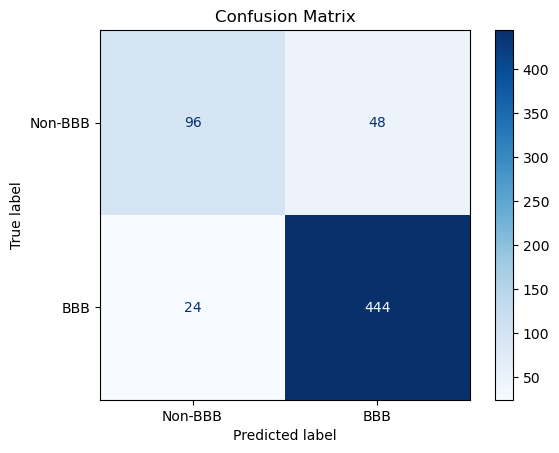

In [21]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-BBB', 'BBB'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

C:\Users\aacti\AppData\Local\Temp\ipykernel_19980\3618241122.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df, y='Feature', x='Importance', palette='Blues_r', legend=False)


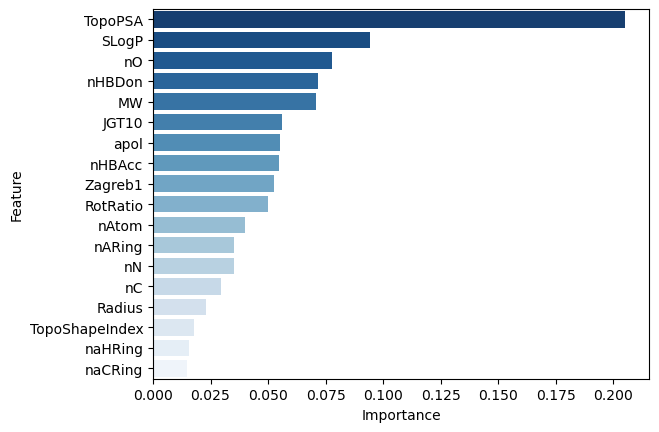

In [22]:
# Plot Feature Importances
importances = best_model.named_steps['rf'].feature_importances_

feature_names = X.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=importances_df, y='Feature', x='Importance', palette='Blues_r', legend=False)
plt.show()

<h2 style="text-align: center; font-size: 40px">6. Conclusion</h2>

<p style="text-align:justify; font-size: 17px; text-indent: 10px">The predictive model exhibits satisfactory overall performance, with an accuracy of 88% and a weighted F1-score of 0.88. Importantly, it shows strong predictive capability for identifying molecules that are capable of crossing the BBB, as reflected by a precision of 0.90, a recall of 0.95, and an F1-score of 0.92 for the positive class. These results highlight the model’s suitability for supporting the early-stage selection of central nervous system (CNS)-active compounds. Nevertheless, the model performs less effectively on the negative class (non-permeable compounds), particularly in terms of recall (0.67), which indicates a tendency to misclassify some non-permeable molecules. Future efforts should focus on improving the detection of the negative class, potentially through class balancing techniques or threshold optimization, to enhance the model's discriminative power across both classes.</p>
<p style="text-align:justify; font-size: 17px; text-indent: 10px">Feature importance analysis revealed that topological polar surface area (TopoPSA), lipophilicity (SLogP), molecular weight (MW), the number of hydrogen bond donors (nHBDon), and the number of oxygen atoms (nO) were the most influential descriptors in the model's predictions. These features are consistent with known physicochemical determinants of BBB permeability, suggesting that the model captures meaningful molecular properties.</p>

